In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from dotenv import load_dotenv
from pydantic import BaseModel,Field
from langchain_core.messages import SystemMessage,HumanMessage


In [27]:
load_dotenv()

True

In [78]:
model=ChatGoogleGenerativeAI(model="gemini-2.5-flash")


In [79]:
class GenPost(TypedDict):
    topic:str
    post:str
    evalution:Literal["approved","needs_improvement"]
    feedback:str
    iteration:int
    max_iteration:int

In [80]:
graph=StateGraph(GenPost)

In [81]:
def generate(state:GenPost):
    message=[
        SystemMessage(content="you are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original and hilarious tweet on the topic:"{state['topic']}".
Rules:
-Do NOT use question-answer format.
-Max 280 characters.
-Use observational humor,irony, sarcasm,or cultural references.
-Think in meme logic,punchlines or relatable takes.
-Use simple,day to day english
-This is version {state['iteration']+1}.
""")
    ]
    post=model.invoke(message).content
    return {'post':post}


In [82]:
class Tweeteval(BaseModel):
    evalution:Literal["approved","needs_improvement"]=Field(description="final evalution")
    feedback: str=Field(...,description="Feedback for the tweet.")
str_model=model.with_structured_output(Tweeteval)

In [83]:
def evaluate(state:GenPost):
    message=[
        SystemMessage(content='you are a ruthless, no-laugh-given Twitter critic.You evaluate tweets based on humor, originality,virality,and tweet form '),
        HumanMessage(content=f"""Evaluate the following tweet:  
            1. Originality - Is this fresh,or have or you seen it a hundred times before?
            2. Humor - Did it genuinely make you smile, laugh, or chuckle?
            3. Punchiness - Is it short,sharp and scroll-stopping>
            4. Virality Potential - Would people retweet or share it?
            5. Format - Is it a well-formed tweet (not a setup-punchline joke,not a Q&A joke,and under 280 characters)
            
        Auto-reject if:
            - It's written in question-answer format(e.g., "Why did..." or "What happens when....")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Don't end with generic, throwaway or deflating line weaken the humor(e.g., "Masterpieces")
        ### Respond only in structured format:
        - evaluation:"approved"or "need_improvement"
        - feedback: One paragrapgh explaining the strengths and weaknesses 
        """
        )
    ]
    response=str_model.invoke(message)
    return {"evalution":response.evalution,'feedback':response.feedback}

In [84]:
def optimize(state:GenPost):
    message=[
        SystemMessage(content="You punch up tweets for virality and humor on given feedback"),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
    "{state['feedback']}"
    Topic:"{state['topic']}
    Original tweets:{state['post']}
Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response=model.invoke(message).content
    iteration=state['iteration']+1
    return {"post":response,"iteration":iteration}

In [85]:
def route_evaluation(state:GenPost):
    if state['evalution']=='approved' or state['iteration']>=state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [86]:
graph.add_node("generate",generate)
graph.add_node("evaluation",evaluate)
graph.add_node("optimize",optimize)

In [87]:
graph.add_edge(START,'generate')
graph.add_edge('generate','evaluation')
graph.add_conditional_edges('evaluation',route_evaluation,{'approved':END,'needs_improvement':'optimize'})
graph.add_edge('optimize','evaluation')

In [88]:
wf=graph.compile()

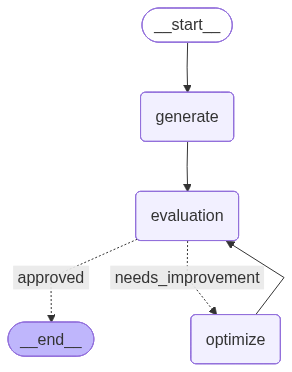

In [89]:
from IPython.display import Image
Image(wf.get_graph().draw_mermaid_png())

In [90]:
intial_state={
    "topic":"Indian Railways",
    "iteration":1,
    "max_iteration":5
}
wf.invoke(intial_state)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 48.287657407s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  sec

{'topic': 'Indian Railways',
 'post': "Here's a punchier, viral-ready version:\n\n---\n\n**Indian Railways delays:** Not late, just an unsolicited, mandatory therapy session. You've got hours to re-evaluate every life choice that led you to *this* platform. Enjoy! 🚂 #IndianRailways #TrainDelays",
 'evalution': 'needs_improvement',
 'feedback': 'You have not provided the tweet to be evaluated. Please provide the tweet so I can assess its humor, originality, virality, and adherence to tweet form.',
 'iteration': 5,
 'max_iteration': 5}